In [2]:
%%writefile sound.py
import numpy as np
import time
from scipy.signal import lfilter
from functools import reduce


class SoundController:
    # https://python-sounddevice.readthedocs.io/en/0.3.15/api/streams.html#sounddevice.OutputStream
    
    default_cfg = {
        "device": [1, 26],
        "n_channels": 10,
        "sounds": {
            "noise": {"amp": 0.5, "channels": [6]},
            "background": {"freq": 10000, "amp": 0.23, "harmonics": True, "channels": [6]},
            "target": {"freq": 660, "amp": 0.15, "harmonics": True, "channels": [6]}, 
            "distractor1": {"freq": 860, "amp": 0.15, "harmonics": True, "channels": [1, 3], "enabled": False},
            "distractor2": {"freq": 1060, "amp": 0.25, "harmonics": True, "channels": [1, 3], "enabled": False},
            "distractor3": {"freq": 1320, "amp": 0.2, "harmonics": True, "channels": [1, 3], "enabled": False}
        },
        "pulse_duration": 0.05,
        "sample_rate": 44100,
        "latency": 0.25,
        "volume": 0.7,
        "roving": 5.0,
        "file_path": "sounds.csv"
    }
    
    @classmethod
    def get_pure_tone(cls, freq, duration, sample_rate=44100):
        x = np.linspace(0, duration * freq * 2*np.pi, int(duration*sample_rate), dtype=np.float32)
        return np.sin(x)

    @classmethod
    def get_harm_stack(cls, base_freq, duration, threshold=1500, sample_rate=44100):
        harmonics = [x * base_freq for x in np.arange(20) + 2 if x * base_freq < threshold]  # first 20 enouch
        freqs = [base_freq] + harmonics
        x = np.linspace(0, duration, int(sample_rate * duration))
        y = reduce(lambda x, y: x + y, [(1./(i+1)) * np.sin(base_freq * 2 * np.pi * x) for i, base_freq in enumerate(freqs)])
        return y / y.max()  # norm to -1 to 1
    
    @classmethod
    def get_cos_window(cls, tone, win_duration, sample_rate=44100):
        x = np.linspace(0, np.pi/2, int(win_duration * sample_rate), dtype=np.float32)
        onset =  np.sin(x)
        middle = np.ones(len(tone) - 2 * len(x))
        offset = np.cos(x)
        return np.concatenate([onset, middle, offset])

    @classmethod
    def get_tone_stack(cls, cfg):
        # silence
        silence = np.zeros(2, dtype='float32')
        sounds = {'silence': np.column_stack([silence for x in range(cfg['n_channels'])])}

        # noise
        filter_a = np.array([0.0075, 0.0225, 0.0225, 0.0075])
        filter_b = np.array([1.0000,-2.1114, 1.5768,-0.4053])

        noise = np.random.randn(int(0.25 * cfg['sample_rate']))  # 250ms of noise
        noise = lfilter(filter_a, filter_b, noise)
        noise = noise / np.abs(noise).max() * cfg['sounds']['noise']['amp']
        noise = noise.astype(np.float32)
        empty = np.zeros((len(noise), cfg['n_channels']), dtype='float32')
        for ch in cfg['sounds']['noise']['channels']:
            empty[:, ch-1] = noise
        sounds['noise'] = empty
        
        # all other sounds
        for key, snd in cfg['sounds'].items():
            if key == 'noise' or ('enabled' in snd and not snd['enabled']):
                continue  # skip noise or unused sounds
                
            if snd['harmonics']:
                tone = cls.get_harm_stack(snd['freq'], cfg['pulse_duration'], sample_rate=cfg['sample_rate']) * cfg['volume']
            else:
                tone = cls.get_pure_tone(snd['freq'], cfg['pulse_duration'], cfg['sample_rate']) * cfg['volume']
            tone = tone * cls.get_cos_window(tone, 0.01, cfg['sample_rate'])  # onset / offset
            tone = tone * snd['amp']  # amplitude
            
            sound = np.zeros([len(tone), cfg['n_channels']], dtype='float32')
            for j in snd['channels']:
                sound[:, j-1] = tone
           
            sounds[key] = sound

        return sounds
        
    @classmethod
    def run(cls, selector, status, cfg):
        """
        selector        mp.Value object to set the sound to be played
        status          mp.Value object to stop the loop
        """
        import sounddevice as sd  # must be inside the function
        import numpy as np
        import time
        
        commutator = {
            -1: 'noise',
            0:  'silence',
            1:  'background',
            2:  'target',
            3:  'distractor1',
            4:  'distractor2',
            5:  'distractor3',
            6:  'distractor4',
            7:  'distractor5'
        }
        
        sounds = cls.get_tone_stack(cfg)

        sd.default.device = cfg['device']
        sd.default.samplerate = cfg['sample_rate']
        stream = sd.OutputStream(samplerate=cfg['sample_rate'], channels=cfg['n_channels'], dtype='float32', blocksize=256)
        stream.start()

        next_beat = time.time() + cfg['latency']
        with open(cfg['file_path'], 'w') as f:
            f.write("time,id\n")

        while status.value > 0:
            if status.value == 2:  # running state
                t0 = time.time()
                if t0 < next_beat:
                    #time.sleep(0.0001)  # not to spin the wheels too much
                    if stream.write_available > 2:
                        stream.write(sounds['silence'])  # silence
                    continue

                roving = 10**((np.random.rand() * cfg['roving'] - cfg['roving']/2.0)/20.)
                roving = roving if int(selector.value) > -1 else 1  # no roving for noise
                stream.write(sounds[commutator[int(selector.value)]] * roving)
                with open(cfg['file_path'], 'a') as f:
                    f.write(",".join([str(x) for x in (t0, selector.value)]) + "\n")

                next_beat += cfg['latency']
                
                if stream.write_available > 2:
                    stream.write(sounds['silence'])  # silence
            
            else:  # idle state
                next_beat = time.time() + cfg['latency']
                time.sleep(0.05)
                
        stream.stop()
        print('Sound stopped')

Overwriting sound.py


In [1]:
import numpy as np
import time, os
import multiprocess as mp
import matplotlib.pyplot as plt

from scipy.signal import lfilter
from sound import SoundController

### Building sound stack

In [2]:
import numpy as np
import time, os
from sound import SoundController

cfg = SoundController.default_cfg
sounds = SoundController.get_tone_stack(cfg)

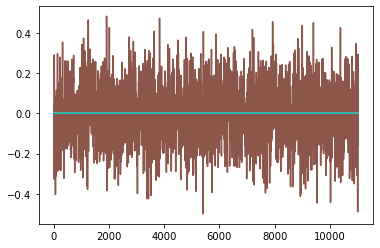

In [3]:
import matplotlib.pyplot as plt

_ = plt.plot(sounds['noise'])

### Roving and onset window

In [5]:
from sound import SoundController

duration = 0.05
freq = 440

tone = SoundController.get_pure_tone(freq, duration)
tone = tone * SoundController.get_cos_window(tone, 0.01)

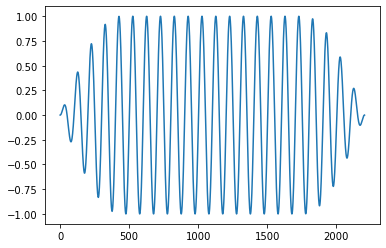

In [6]:
import matplotlib.pyplot as plt
plt.plot(tone)

### Building noise

In [7]:
import numpy as np
from scipy.signal import lfilter

sample_rate = 44100

filter_a = np.array([0.0075, 0.0225, 0.0225, 0.0075])
filter_b = np.array([1.0000,-2.1114, 1.5768,-0.4053])

noise = np.random.randn(sample_rate)
noise = lfilter(filter_a, filter_b, noise)
noise = noise / np.abs(noise).max() * 0.5
noise = noise.astype(np.float32)

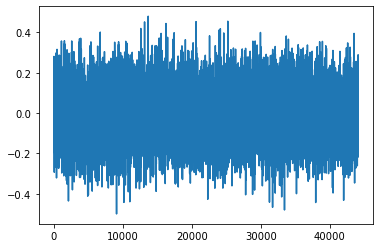

In [8]:
import matplotlib.pyplot as plt

plt.plot(noise)

### Testing sound pulses without MP

In [2]:
import numpy as np
import time, os
import multiprocess as mp
from sound import SoundController

# sound selector: 0 - silence, 1 - tone 1, 2 - tone 2
selector = mp.Value('i', -1)

# loggin status: 1 - idle, 2 - running, 0 - stopped
status = mp.Value('i', 2)

cfg = SoundController.default_cfg
#cfg['device'] = [1, 26]  # 'M-Audio Delta ASIO'
#SoundController.run(selector, status, cfg)

# nothing happens for a second
time.sleep(1)

status.value = 2
for i in range(6):
    time.sleep(1)
    selector.value = -1 if selector.value == 1 else 1

# stop
status.value = 0
time.sleep(0.2)

### Testing sound pulses with MP

In [2]:
import numpy as np
import time, os
import multiprocess as mp
from sound import SoundController

# sound selector: 0 - silence, 1 - tone 1, 2 - tone 2
selector = mp.Value('i', 1)

# loggin status: 1 - idle, 2 - running, 0 - stopped
status = mp.Value('i', 1)

cfg = SoundController.default_cfg
cfg['device'] = [1, 26]  # 'M-Audio Delta ASIO'
sc = mp.Process(target=SoundController.run, args=(selector, status, cfg))
sc.start()

# nothing happens for a second
time.sleep(1)

status.value = 2
for i in range(10):
    time.sleep(1)
    selector.value = -1 if selector.value == 1 else 1

# stop
status.value = 0
time.sleep(0.2)
sc.join()

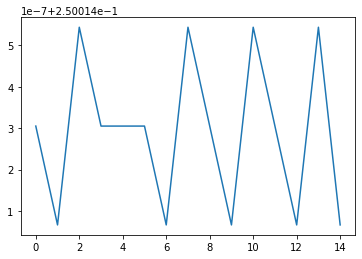

In [3]:
import matplotlib.pyplot as plt

ds = np.loadtxt('test_sound_log.csv', delimiter=',', skiprows=1)
plt.plot(np.diff(ds[:, 0]))

### Sounddevice playground

In [1]:
import sounddevice as sd
[x for x in sd.query_devices() if x['name'].find('ASIO') > 0]

[{'name': 'M-Audio Delta ASIO',
  'hostapi': 2,
  'max_input_channels': 6,
  'max_output_channels': 10,
  'default_low_input_latency': 0.0014512471655328798,
  'default_low_output_latency': 0.0014512471655328798,
  'default_high_input_latency': 0.09287981859410431,
  'default_high_output_latency': 0.09287981859410431,
  'default_samplerate': 44100.0}]

In [1]:
import sounddevice as sd
import numpy as np
import keyboard  # using module keyboard

sd.default.device = [1, 26]
sd.default.samplerate = 44100
stream = sd.OutputStream(samplerate=44100, channels=10, dtype='float32')

In [2]:
# 3rd channel - left arena speaker
# 1st channel - right arena speaker

In [3]:
duration = 0.5

x1 = np.linspace(0, duration * 220 * 2*np.pi, int(duration*44100), dtype=np.float32)
x2 = np.linspace(0, duration * 440 * 2*np.pi, int(duration*44100), dtype=np.float32)
y1 = np.sin(x1)
y2 = np.sin(x2)
sil = np.zeros(len(x1), dtype=np.float32)

In [5]:
stream.start()

try:
    while True:  # making a loop
        if keyboard.is_pressed('q'):  # if key 'q' is pressed 
            break  # finishing the loop

        stream.write(np.column_stack([y1, sil, sil, sil, sil, sil, sil, y2, sil, sil]) * 0.8)
        #stream.write(np.column_stack([y2, y2, y2, y2, y2, y2, y2, y2, y2, y2]) * 0.8)
    
finally:
    stream.stop()